In [1]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"
import jax.numpy as jnp
from jax import random
from model import MonetaryModel
import matplotlib.pyplot as plt

In [ ]:
def get_prev_shock(model, P, T, prev_shock):
    """
    """
    shock_series = []
    measurement_series = []

    key = random.PRNGKey(0)
    shock_matrix = random.normal(key, shape=(30, 3))

    for t in range(T):
        current_shock = model.transition(prev_shock, shock_override=shock_matrix[t])
        measurement = model.measurement(P, current_shock)
        shock_series.append(current_shock)
        measurement_series.append(measurement)
        prev_shock = current_shock

    shock_series = jnp.array(shock_series)
    measurement_series = jnp.array(measurement_series)

    return measurement_series

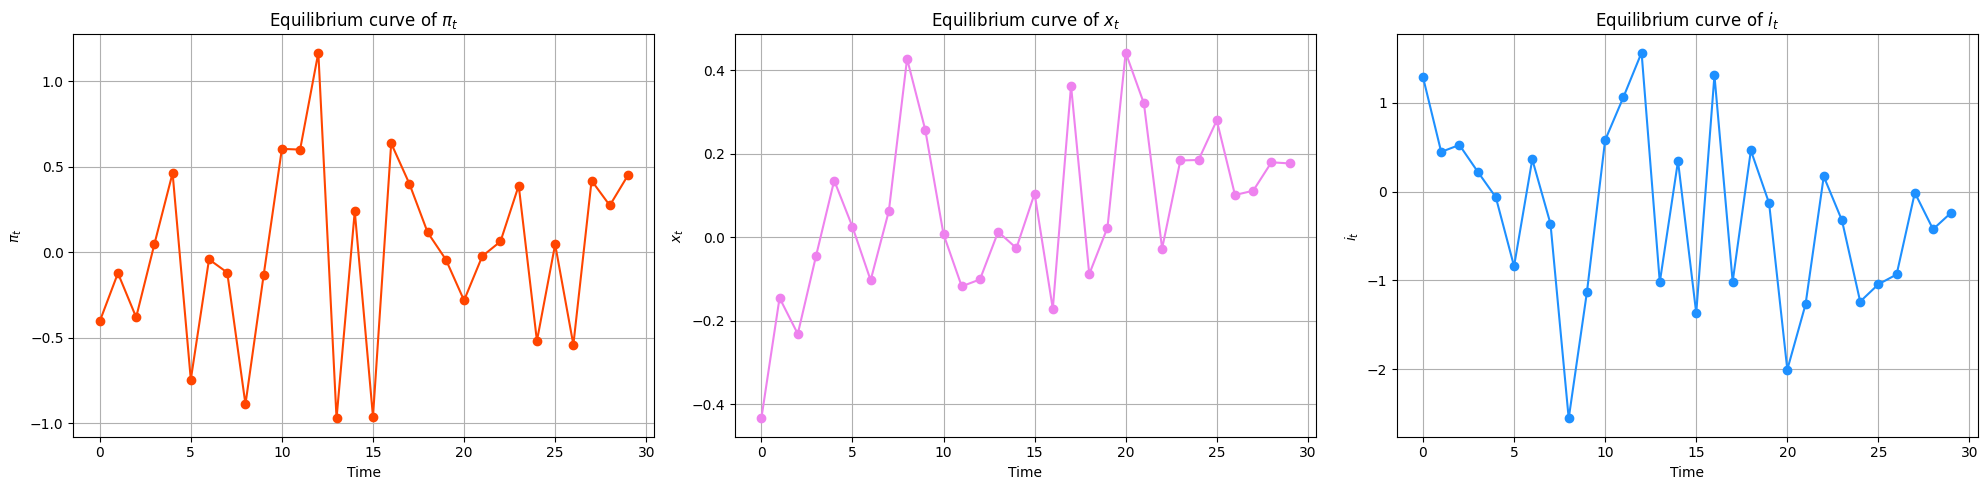

In [ ]:
# Q1
from config import benchmark_dict
model = MonetaryModel(**benchmark_dict)     # Initialize model
T = 30      # simulate period
P = model.solve_P() 
init_state = jnp.zeros(3, dtype=jnp.float32)
series = get_prev_shock(model, P, T, init_state) 

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
labels = [r'$\pi_{t}$', r'$x_{t}$', r'$i_{t}$']
colors = ['orangered', 'violet', 'dodgerblue']

for i in range(3):
    axes[i].plot(range(len(series)), series[:, i], marker='o', linestyle='-', color=colors[i])
    axes[i].set_title(f'Equilibrium curve of {labels[i]}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(labels[i])
    axes[i].grid()

plt.tight_layout()
plt.show()


In [26]:
def get_changed_series(model, P, index, std_change=1.0, periods=30):
    # One std dev change of different shock at t=0
    t = 0
    T = periods      # Number of periods

    shock_index = index    
    std_dev_change = std_change
    changed_shock = jnp.zeros(3, dtype=jnp.float32).at[shock_index].set(std_dev_change)
    shocks = jnp.zeros((T, 3), dtype=jnp.float32).at[t].set(changed_shock)  

    # Simulate for T periods
    shock_series = []
    measurement_series = []
    init_shock = jnp.zeros(3, dtype=jnp.float32)
    prev_shocks = get_prev_shock(model, P, T, init_shock) 
    prev_shock = prev_shocks[-1]

    for t in range(T):
        current_shock = model.transition(prev_shock, shock_override=shocks[t])
        #current_shock = model.transition(prev_shock, shock_override=shocks[t],rho_r=0.8, rho_u=0.8)
        measurement = model.measurement(P, current_shock)
        shock_series.append(current_shock)
        measurement_series.append(measurement)
        prev_shock = current_shock

    shock_series = jnp.array(shock_series)
    measurement_series = jnp.array(measurement_series)

    return shock_series, measurement_series

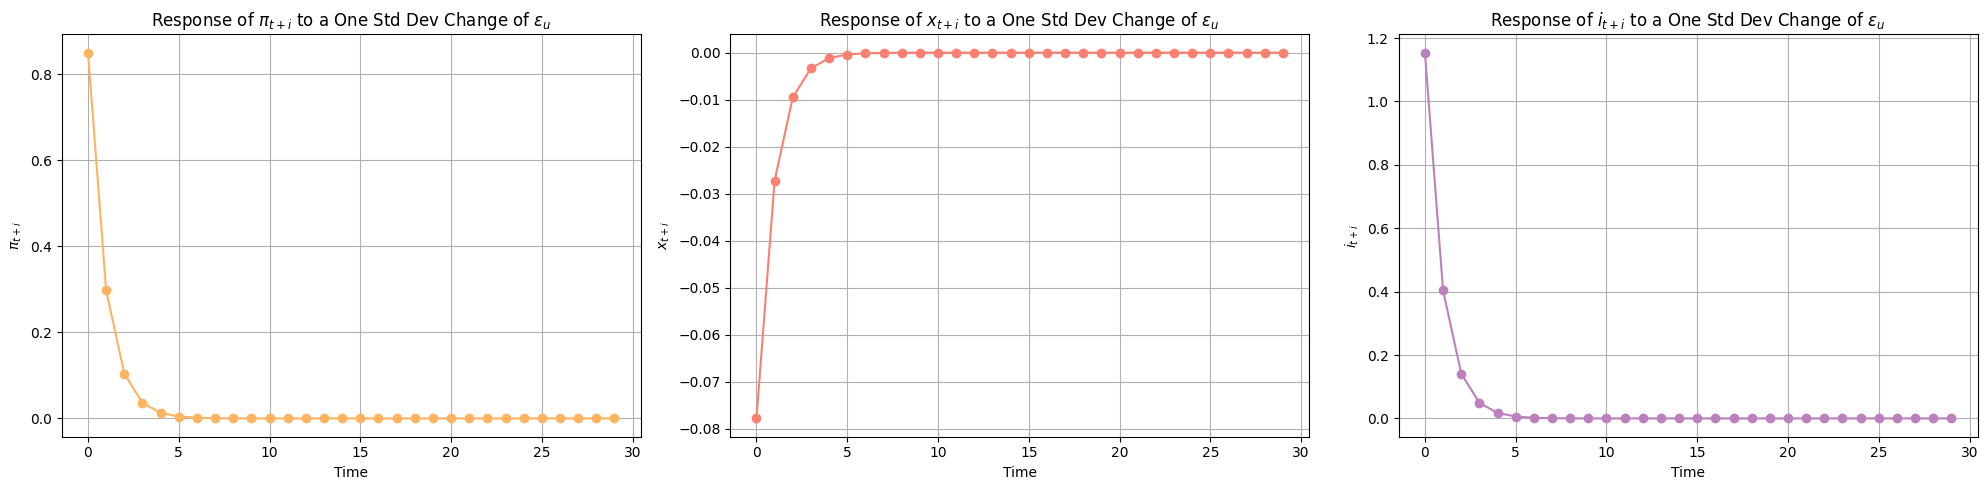

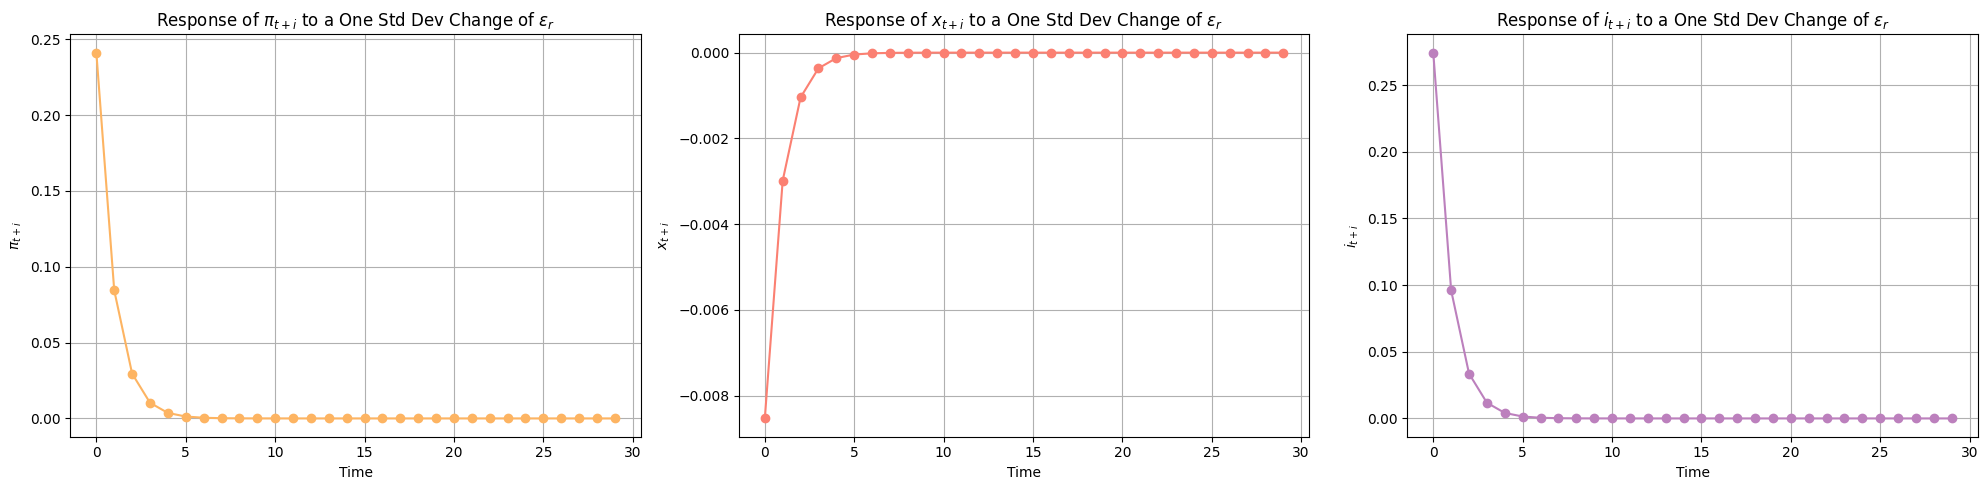

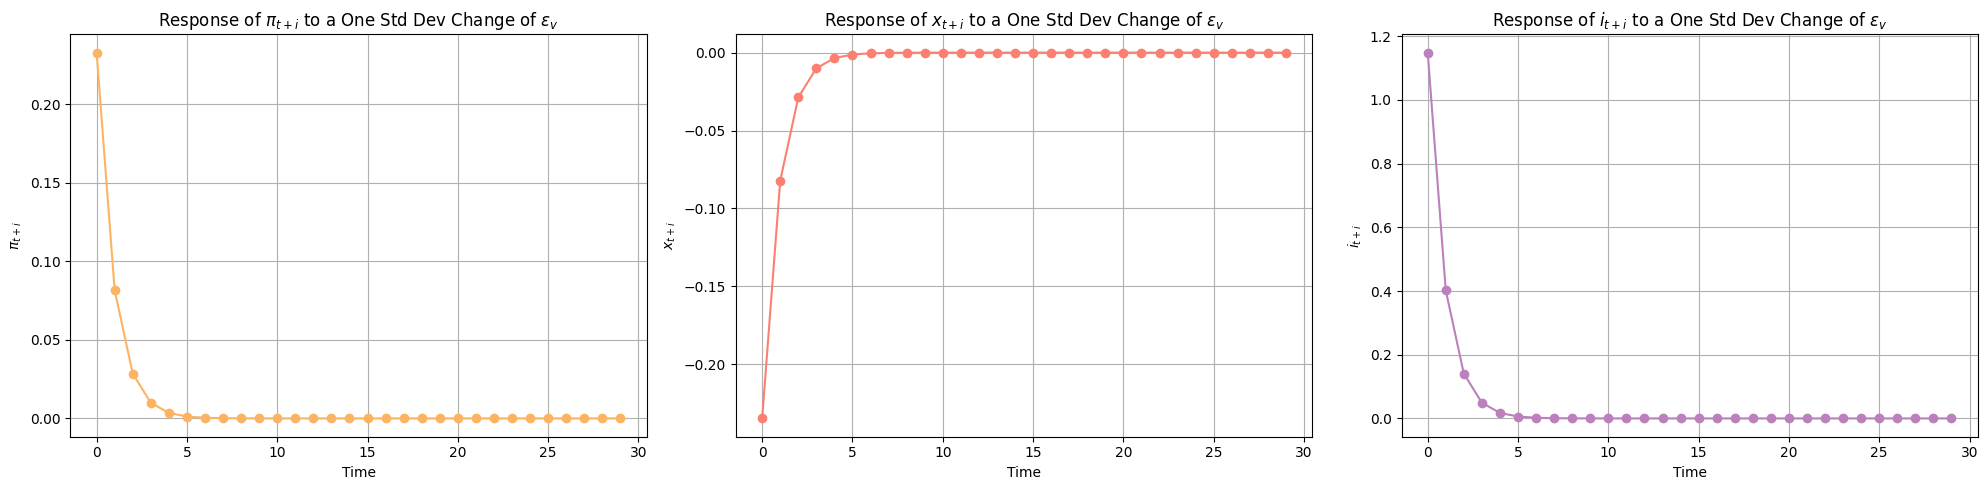

In [27]:
# q2 
indexs = [0, 1, 2]   # 0 : u, 1 : r, 2 : nu.

for index in indexs:
    P1 = model.solve_P()    
    shock_series_posi, measurement_series_posi = get_changed_series(model, P1, index, 1.0)
    #shock_series_nega, measurement_series_nega = get_changed_series(model, P1, index, -1.0)
    
    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    labels = [r'$\pi_{t+i}$', r'$x_{t+i}$', r'$i_{t+i}$']
    shocks_name = [r'$ε_{u}$', r'$ε_{r}$', r'$ε_{v}$']

    color_name = 'Set3' 
    select1 = (0.45,0.3,0.8)
    colors_1 = plt.get_cmap(color_name)(select1)
    select2 = (0.05,0.35,0.60)
    colors_2 = plt.get_cmap(color_name)(select2)

    for i in range(3):
        axes[i].plot(range(len(measurement_series_posi)), measurement_series_posi[:, i], marker='o', linestyle='-', color=colors_1[i], label='Positive Std Change')
        #axes[i].plot(range(len(measurement_series_nega)), measurement_series_nega[:, i], marker='o', linestyle='-', color=colors_2[i] , label='Negative Std Change')
        axes[i].set_title(f'Response of {labels[i]} to a One Std Dev Change of {shocks_name[index]}')
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel(labels[i])
        axes[i].grid()

    plt.tight_layout()
    plt.show()

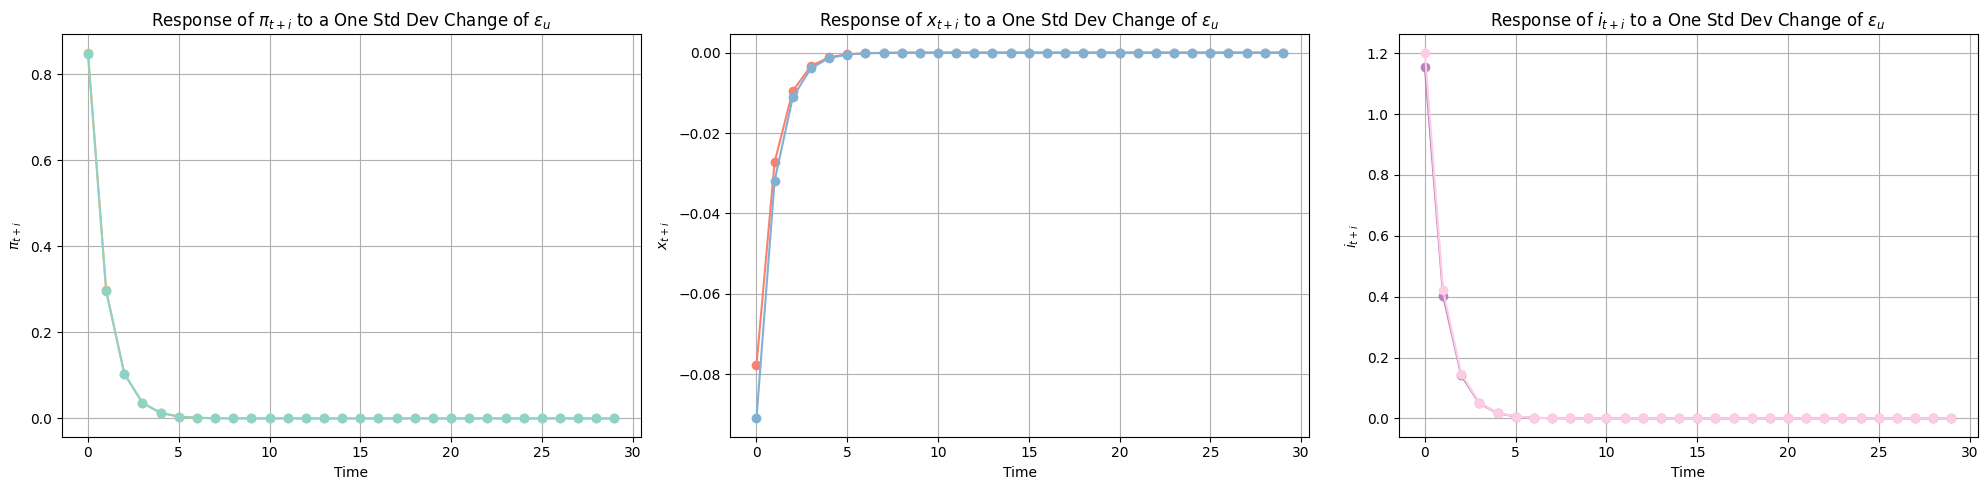

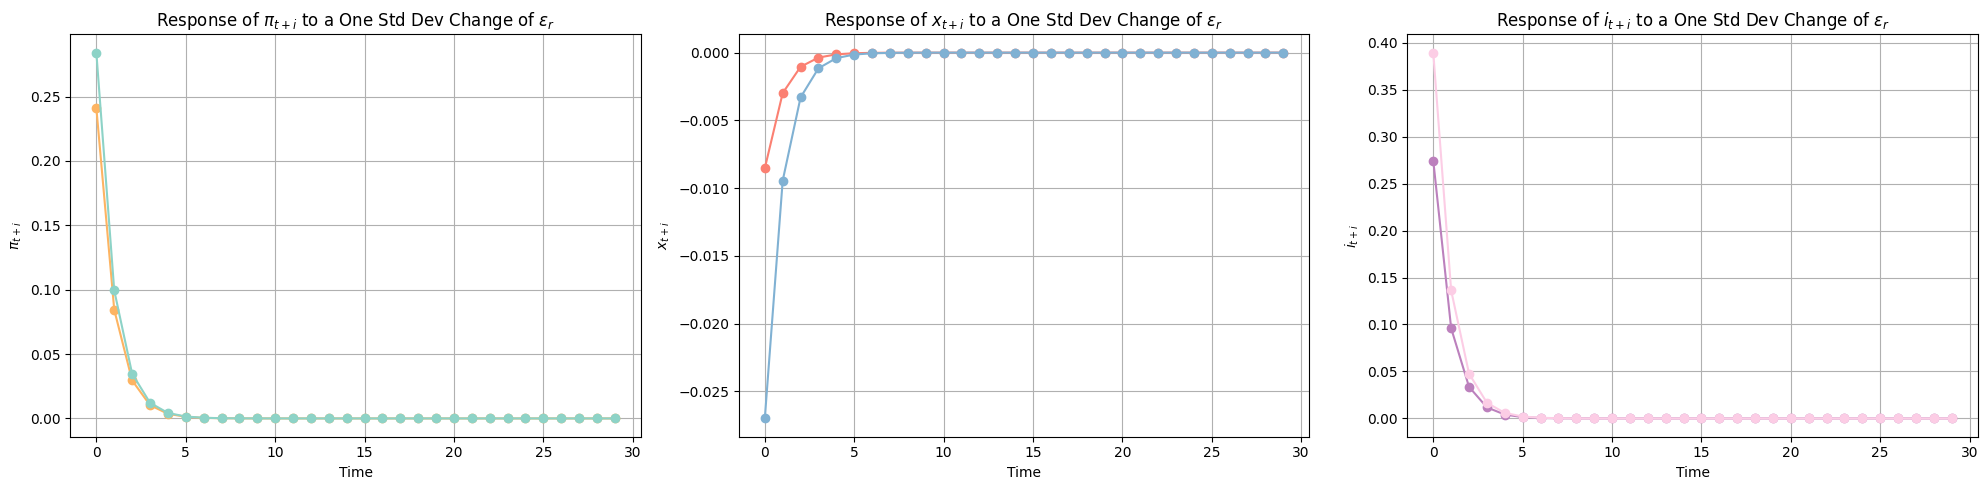

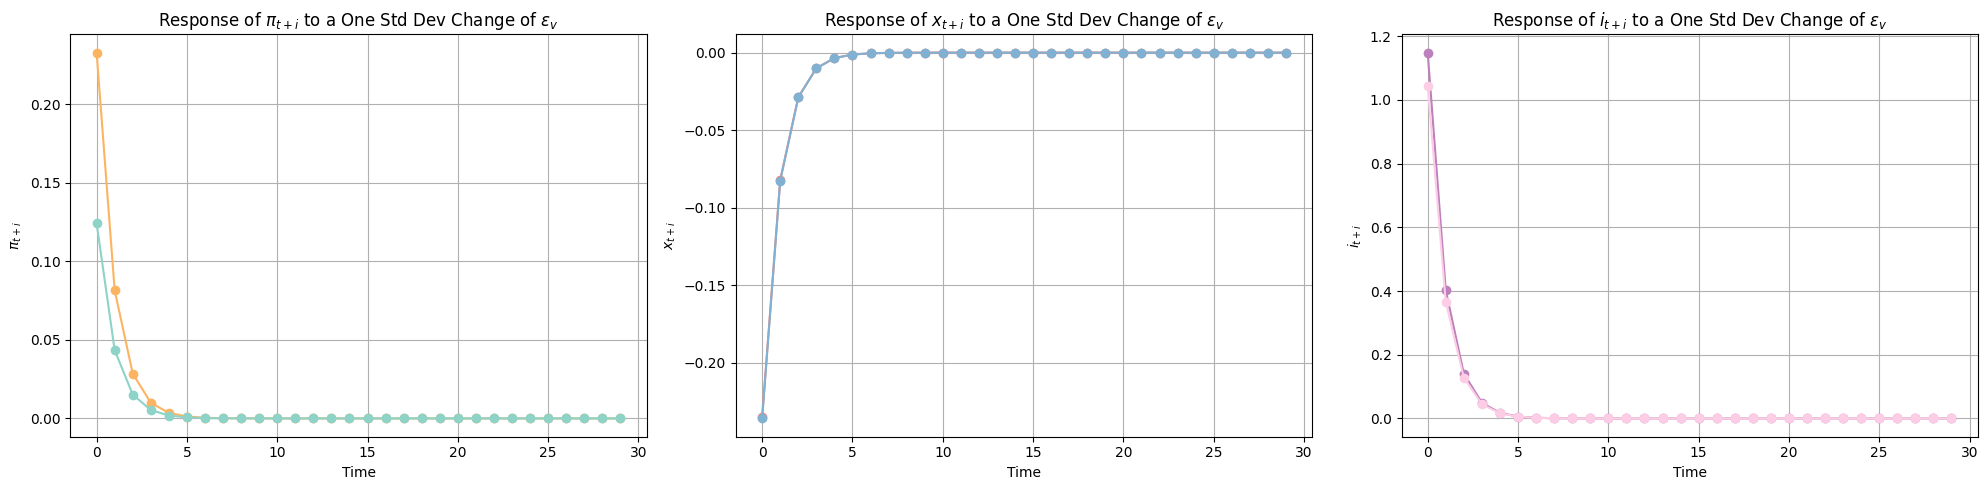

In [23]:
# q3 kappa change vs q2 unchanged
indexs = [0, 1, 2]

for index in indexs:
    P1 = model.solve_P()    
    shock_series, measurement_series = get_changed_series(model, P1, index)

    P2 = model.solve_P(kappa=0.5)    #, rho_r=0.8, rho_u=0.8, phi_pi=5, phi_x=3
    changed_shock_series, changed_measurement_series = get_changed_series(model, P2, index)
    
    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    labels = [r'$\pi_{t+i}$', r'$x_{t+i}$', r'$i_{t+i}$']
    shocks_name = [r'$ε_{u}$', r'$ε_{r}$', r'$ε_{v}$']

    color_name = 'Set3' 
    select1 = (0.45,0.3,0.8)
    colors_1 = plt.get_cmap(color_name)(select1)
    select2 = (0.05,0.35,0.60)
    colors_2 = plt.get_cmap(color_name)(select2)

    for i in range(3):
        axes[i].plot(range(len(measurement_series)), measurement_series[:, i], marker='o', linestyle='-', color=colors_1[i])
        axes[i].plot(range(len(changed_measurement_series)), changed_measurement_series[:, i], marker='o', linestyle='-', color=colors_2[i])
        axes[i].set_title(f'Response of {labels[i]} to a One Std Dev Change of {shocks_name[index]}')
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel(labels[i])
        axes[i].grid()

    plt.tight_layout()
    plt.show()